## Numerical Loan Approval Dataset

### 1. Setup and Imports

In [56]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, mean_squared_error

# Configure visual settings
sns.set_style('whitegrid')
%matplotlib inline

### 2. Data Loading & EDA(Exploratory Data Analysis.)

In [57]:
# Load the dataset
# '..' means go up one level, then into 'dataset' folder
df = pd.read_csv('../dataset/bank_loan.csv')

# 1. Check the size of the dataset
print(f"Dataset Shape: {df.shape}")  # (Rows, Columns)

# 2. Look at the first 5 rows to understand what the data looks like
display(df.head(10))

# 3. Check data types and missing values
print("\n--- Data Info ---")
df.info()

# 4. Check for missing values in each column
print("\n--- Missing Values Count ---")
print(df.isnull().sum())

Dataset Shape: (5000, 14)


,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP.Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal.Loan       5000 non-null   int64  
 10  Securities.Account  5000 non-null   int64  
 11  CD.Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB

--- Missing Values Count ---
ID     

### 3. Data Preprocessing (Cleaning)

In [58]:
# 1. Drop useless columns
# ID is just an index, and ZIP Code is too messy for simple regression
df.drop(['ID', 'ZIP.Code'], axis=1, inplace=True)

# 2. Check for negative experience
print(f"Negative Experience Count: {(df['Experience'] < 0).sum()}")

# 3. Fix Negative Experience
# We convert negative values to positive (assuming it was a typo)
df['Experience'] = df['Experience'].abs()

# 4. Verify no missing values exist (Just to be safe)
print("Missing values:", df.isnull().sum().sum())

Negative Experience Count: 52
Missing values: 0


### Visualizing and Handling the Outliers

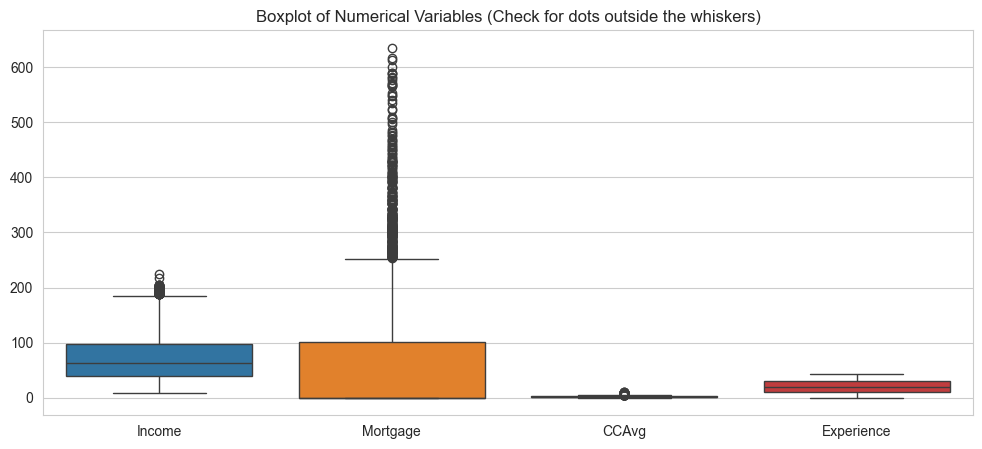

In [59]:
# --- Visualize Outliers ---
# We check Income, Mortgage, and CCAvg because financial data often has outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[['Income', 'Mortgage', 'CCAvg', 'Experience']])
plt.title("Boxplot of Numerical Variables (Check for dots outside the whiskers)")
plt.show()

In [83]:
# --- Handle Outliers (Capping at 99th Percentile) ---

# List of columns to check for outliers
cols_to_cap = ['Income', 'Mortgage', 'CCAvg']

for col in cols_to_cap:
    # 1. Find the value at the 99th percentile (Top 1%)
    upper_limit = df[col].quantile(0.99)
    
    # 2. Count how many outliers we are about to cap
    outlier_count = (df[col] > upper_limit).sum()
    print(f"Capping {outlier_count} outliers in '{col}' at value: {upper_limit}")
    
    # 3. Cap the values
    # If value > upper_limit, replace it with upper_limit. Otherwise, keep it.
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

print("\nOutlier handling complete. Extreme values have been capped.")

Capping 0 outliers in 'Income' at value: 193.0
Capping 0 outliers in 'Mortgage' at value: 431.0
Capping 0 outliers in 'CCAvg' at value: 8.0

Outlier handling complete. Extreme values have been capped.


### 4. Feature Engineering & Scaling

In [85]:
# --- Cell: Feature Engineering & Scaling ---
from sklearn.preprocessing import LabelEncoder

# 1. Encoding 'Education' using LabelEncoder
# This converts categories (1, 2, 3) into (0, 1, 2)
# preserving the order: Undergrad < Graduate < Professional
le = LabelEncoder()
df['Education'] = le.fit_transform(df['Education'])

# 2. Define Features (X) and Target (y)
X = df.drop('Personal.Loan', axis=1)
y = df['Personal.Loan']

# 3. Feature Scaling (Mandatory for KNN)
# This forces all columns (Income, Mortgage, etc.) onto the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split Data into Training and Testing
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Data Setup Complete!")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Data Setup Complete!
Training Shape: (4000, 11)
Testing Shape: (1000, 11)


### 5. Model 1: Linear Regression

Linear Regression Accuracy: 92.40%
Saved: ../results/linear_regressionLR_confusion_matrix.png


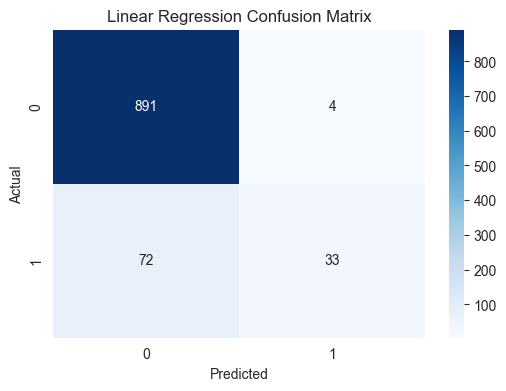

In [97]:
# --- Linear Regression Implementation ---
# 1. Train
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 2. Predict (Continuous values)
y_pred_lin = lin_reg.predict(X_test)

# 3. Convert to Class (0 or 1)
# Threshold: If prediction > 0.5, we classify as 1 (Loan Approved)
y_pred_class_lin = [1 if val > 0.5 else 0 for val in y_pred_lin]

# 4. Results
print(f"Linear Regression Accuracy: {accuracy_score(y_test, y_pred_class_lin):.2%}")

# 5. Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_class_lin), annot=True, fmt='d', cmap='Blues')
plt.title('Linear Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../results/linear_regression/LR_confusion_matrix.png')
print("Saved: ../results/linear_regressionLR_confusion_matrix.png")
plt.show()

#### Interpretation of Linear Regression Confusion Matrix:

* *True Negatives (891):* 
    *  The model correctly identified 891 customers who did not accept the personal loan. 
    *  It remains extremely reliable at identifying non-customers.

* *False Positives (4):* 
    *  The model only made 4 mistakes where it predicted someone would take the loan, but they didn't. 
    *  This means the model still has very high Precision—when it says "Yes," it is usually right.

* *False Negatives (72):* 
    *  The model missed 72 people who actually accepted the loan (predicting they wouldn't). 
    *  This number slightly increased after outlier capping, confirming that Linear Regression 
    *  remains too "conservative" and fails to capture the majority of actual loan customers.

* *True Positives (33):* 
    *  It correctly found 33 customers who accepted the loan. 
    *  This is a low Recall rate (33 out of 105 actual positives), which is why KNN is the better model here.

#### Saving Linear Regression Predictions to predistions.csv

In [89]:
# --- Save Predictions to CSV ---

# 1. Create a DataFrame with Actual vs. Predicted values
# y_test: The actual answers (0 or 1)
# y_pred_class_lin: The 0 or 1 prediction
# y_pred_lin: The raw score (e.g., 0.85) - Optional but useful to see "confidence"
results_df = pd.DataFrame({
    'Actual_Status': y_test,
    'Predicted_Status': y_pred_class_lin,
    'Prediction_Score': y_pred_lin
})

# 2. Save it to the specific folder structure
# index=False ensures we don't save the row numbers as a separate column
results_df.to_csv('../results/linear_regression/LR_predictions.csv', index=False)

print("Successfully saved LR_predictions.csv!")
print(results_df.head()) # Show the first few rows to verify

Successfully saved LR_predictions.csv!
      Actual_Status  Predicted_Status  Prediction_Score
1501              0                 0         -0.153391
2586              1                 0          0.316348
2653              0                 0          0.172701
1055              0                 0         -0.147360
705               0                 0         -0.026837


### 6. Model 2: K-Nearest Neighbors (KNN)

Saved: ../results/KNN/error_plot.png


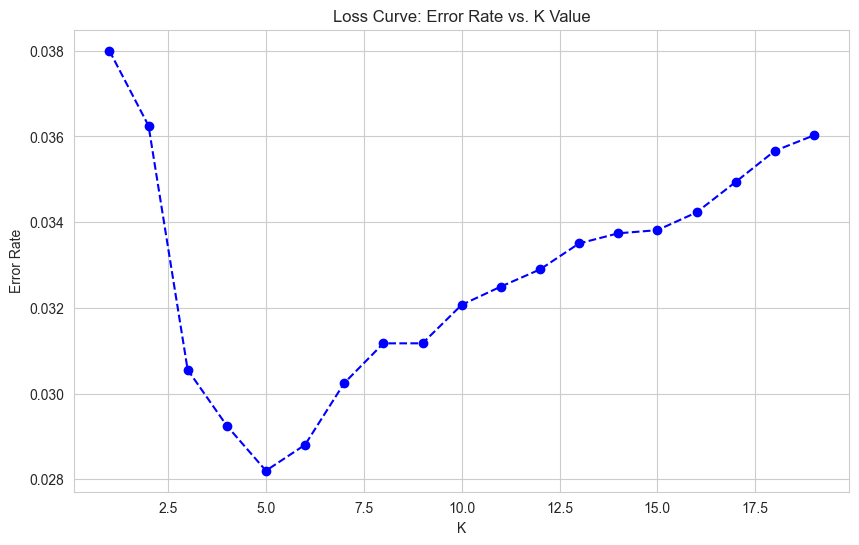

Best K found: 5
KNN Accuracy: 96.40%
Saved: ../results/KNN/KNN_confusion_matrix.png


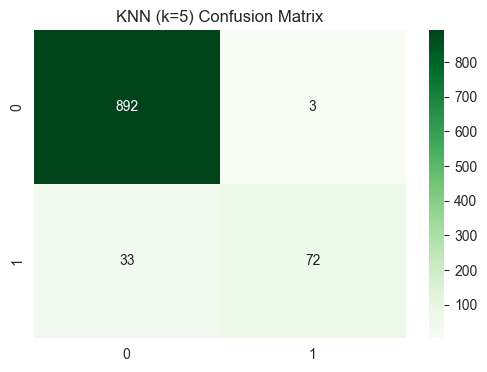

In [100]:
# --- KNN Implementation & Tuning ---
# 1. Hyperparameter Tuning (Finding the best K)
error_rate = []
k_range = range(1, 20)

for i in k_range:
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # Calculate MSE (Mean Squared Error) for the Loss Curve
    error_rate.append(np.mean((pred_i - y_test) ** 2))

# 2. Plot the Loss Curve 
##A Loss Curve typically shows how "wrong" a model is as it learns or changes. The lower the value, the better.
plt.figure(figsize=(10,6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o')
plt.title('Loss Curve: Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.savefig('../results/KNN/error_plot.png')
print("Saved: ../results/KNN/error_plot.png")
plt.show()

# 3. Train Final Model with Best K (e.g., K=5 or lowest point on graph)
best_k = error_rate.index(min(error_rate)) + 1
print(f"Best K found: {best_k}")

knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)
y_pred_class_knn = [1 if val > 0.5 else 0 for val in y_pred_knn]

# 4. Final KNN Results
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_class_knn):.2%}")
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_class_knn), annot=True, fmt='d', cmap='Greens')
plt.title(f'KNN (k={best_k}) Confusion Matrix')
plt.savefig('../results/KNN/KNN_confusion_matrix.png')
print("Saved: ../results/KNN/KNN_confusion_matrix.png")
plt.show()

In [104]:
#### Metric Comparison Table:
# --------------------------------------------------------------------------------------------------
# Metric                Linear Regression       KNN (K=5)           Improvement
# --------------------------------------------------------------------------------------------------
# Accuracy              92.40%                  96.40%              +4.0%
# True Positives        33                      72                  Doubled! (>2x better)
# (Caught the Loan)
#
# False Negatives       72                      33                  Halved! (Huge reduction in misses)
# (Missed the Loan)
#
# False Positives       4                       3                   Improved (Lower false alarms)
# (False Alarm)
# --------------------------------------------------------------------------------------------------

# Conclusion: 
# KNN is definitively the superior model for this business case. It provides a 4% boost in overall accuracy 
# and, more importantly, it catches more than twice as many actual loan customers (72 vs 33) 
# while keeping false alarms even lower than Linear Regression. 
# The non-linear decision boundary of KNN was essential for capturing these complex customer patterns.

#### Saving KNN (K-Nearest Neighbors) Predictions to predistions.csv

In [93]:
# --- Save KNN Predictions to CSV ---

# 1. Create a DataFrame
# y_test: Actual values
# y_pred_class_knn: The 0/1 prediction from your best K model
# y_pred_knn: The raw average score from neighbors (e.g., 0.6, 0.8)
results_knn_df = pd.DataFrame({
    'Actual_Status': y_test,
    'Predicted_Status': y_pred_class_knn,
    'Prediction_Score': y_pred_knn
})

# 2. Save to the KNN results folder
results_knn_df.to_csv('../results/KNN/KNN_predictions.csv', index=False)

print("Successfully saved KNN KNN_predictions.csv!")
print(results_knn_df.head())

Successfully saved KNN KNN_predictions.csv!
      Actual_Status  Predicted_Status  Prediction_Score
1501              0                 0               0.0
2586              1                 1               0.8
2653              0                 0               0.2
1055              0                 0               0.0
705               0                 0               0.0


#### prediction.csv Column Breakdown

* Actual_Status: The ground truth labels from the test data.

        0 = Loan Rejected

        1 = Loan Accepted

* Predicted_Status: The final classification decision made by the model.

        0 or 1

* Prediction_Score: The confidence score (probability) of the prediction. For KNN, this is the fraction of neighbors that voted "Yes".

        Score > 0.5 (e.g., 0.6, 0.8, 1.0) → Model predicts 1.

        Score ≤ 0.5 (e.g., 0.0, 0.2, 0.4) → Model predicts 0.

### 7. Final Results: ROC Curve Comparison

Saved: ../results/roc_curve_comparison.png


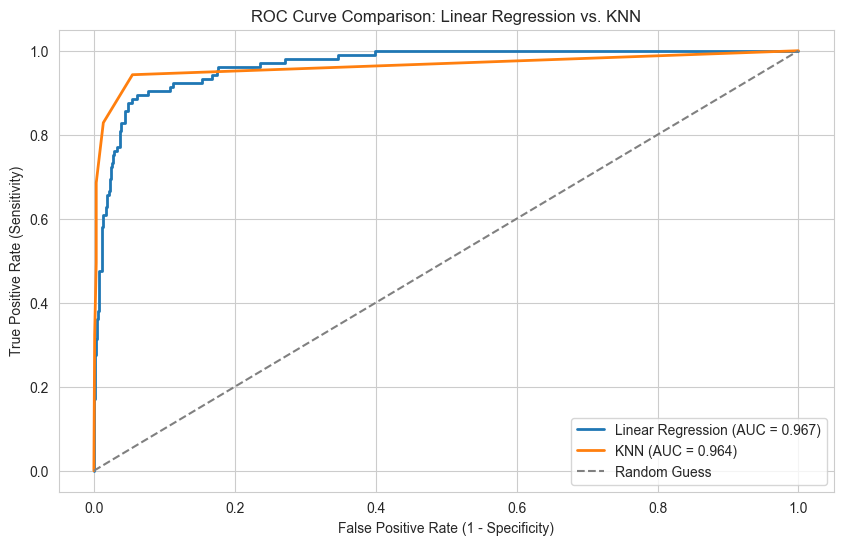

In [98]:
# --- ROC Curve Comparison ---
from sklearn.metrics import roc_curve, auc

# 1. Calculate ROC Metrics for Linear Regression
# We use the raw predictions (y_pred_lin) before thresholding
fpr_lin, tpr_lin, thresholds_lin = roc_curve(y_test, y_pred_lin)
auc_lin = auc(fpr_lin, tpr_lin)

# 2. Calculate ROC Metrics for KNN
# We use the raw predictions from the best KNN model
y_pred_knn_raw = knn_best.predict(X_test)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn_raw)
auc_knn = auc(fpr_knn, tpr_knn)

# 3. Plot Both Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lin, tpr_lin, label=f'Linear Regression (AUC = {auc_lin:.3f})', linewidth=2)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})', linewidth=2)

# Plot Diagonal (Random Guess)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guess')

# Formatting
plt.title('ROC Curve Comparison: Linear Regression vs. KNN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)

# Save for your report
plt.savefig('../results/roc_curve_comparison.png')
print("Saved: ../results/roc_curve_comparison.png")
plt.show()

#### ROC - Receiver Operating Characteristic (The graph above)
The curve measures how good your model is at separating the two classes (Loan Approved vs. Rejected) across **all possible thresholds**.

* **The Goal:** Get as close to the **top-left corner** as possible. The "Area Under the Curve" (AUC) gives you a single score to declare a winner (1.0 is perfect).

* **Interpretation of Your Results:**
    * **Linear Regression (AUC = 0.967):** It actually has a slightly higher "ranking" score. It is excellent at distinguishing low risk from high risk overall.
    * **KNN (AUC = 0.964):** Slightly lower AUC, yet it has **higher Accuracy** ($96.4\%$).

* **Analogy:** Think of AUC as "potential" and Accuracy as "performance." Linear Regression has slightly better theoretical potential (higher AUC), but at the specific decision line we need to use (threshold = 0.5), KNN performs much better (higher Accuracy and True Positives).